# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## How you can use this notebook

You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.

Why?

Because there are many different ways (actually, there's almost an infinite number of ways) to write neural networks.

But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputting some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

*Table 1: Typical architecture of a regression network. Source: Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

Okay, enough talk, let's get started writing code.

To use TensorFlow, we'll import it as the common alias `tf` (short for TensorFlow).

In [1]:
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)

2024-10-15 08:13:21.186791: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 08:13:26.133180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 08:13:27.932724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 08:13:28.437853: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 08:13:32.012579: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version:  2.17.0


## Creating data to view and fit

Since we're working on a **regression problem** (predicting a number) let's create some linear data (a straight line) to model.

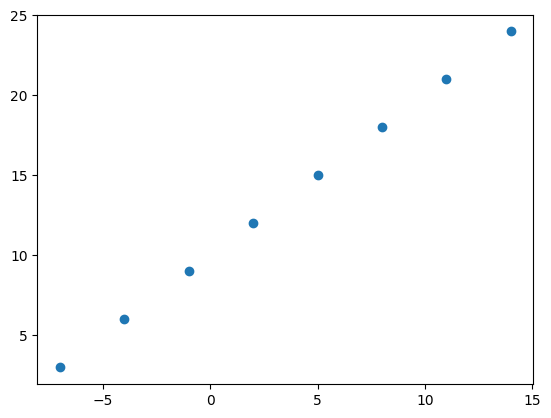

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y);

In [3]:
# The relationship we want to learn
y == X + 10

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Regression input shapes and output shapes

One of the most important concepts when working with neural networks are the input and output shapes.

The **input shape** is the shape of your data that goes into the model.

The **output shape** is the shape of your data you want to come out of your model.

These will differ depending on the problem you're working on.

Neural networks accept numbers and output numbers. These numbers are typically represented as tensors (or arrays).

Before, we created data using NumPy arrays, but we could do the same with tensors.

In [4]:
# Create a demo tensor for our housing price prediction problem
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])

house_info, house_price

I0000 00:00:1728951273.624712    1552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728951278.387663    1552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728951278.387716    1552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728951278.400268    1552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728951278.400311    1552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [5]:
input_shape = X[0].shape
output_shape = y[0].shape

input_shape, output_shape # these are both scalars (no shape)

((), ())

Huh?

From this it seems our inputs and outputs have no shape?

How could that be?

It's because no matter what kind of data we pass to our model, it's always going to take as input and return as output some kind of tensor.

But in our case because of our dataset (only 2 small lists of numbers), we're looking at a special kind of tensor, more specifically a rank 0 tensor or a scalar.

In [6]:
# Let's take a look at the single examples invidually
X[0], y[0]

(-7.0, 3.0)

In [7]:
# Turn our NumPy arrays into tensors with dtype float32
X = tf.cast(tf.constant(X), dtype=tf.float32)
y = tf.cast(tf.constant(y), dtype=tf.float32)
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In our case, we're trying to build a model to predict the pattern between `X[0]` equalling `-7.0` and `y[0]` equalling `3.0`.

So now we get our answer, we're trying to use 1 `X` value to predict 1 `y` value.

You might be thinking, "this seems pretty complicated for just predicting a straight line...".

And you'd be right.

But the concepts we're covering here, the concepts of input and output shapes to a model are fundamental. 

In fact, they're probably two of the things you'll spend the most time on when you work with neural networks: **making sure your input and outputs are in the correct shape**.

## Steps in modelling with TensorFlow

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).

2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
    - Loss: How wrong your model's predictions are compared to the truth labels (minimise this)
    - Optimizer: How your model should update it's internal patterns to better it's predictions.
    - Metrics: Human interpretable values for how well your model is doing.

3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`).
   - Epochs: How many times the model will go through all of the training examples.

4. **Evaluate a model** - Evaluate the model on the test data (how reliable are our model's predictions?)


Let's see these in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for our regression data. And then we'll step through each.

In [8]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model using the Sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=1), y, epochs=5)

Epoch 1/5


I0000 00:00:1728951280.129764   52517 service.cc:146] XLA service 0x7fac84004660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728951280.129829   52517 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-10-15 08:14:40.751497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 08:14:42.127353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 14.0272 - mae: 14.0272
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.8947 - mae: 13.8947
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.7622 - mae: 13.7622
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 13.6297 - mae: 13.6297
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 13.4972 - mae: 13.4972


I0000 00:00:1728951283.390325   52517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
# Check out X and y again
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [10]:
# Try and make a prediction using our model
y_pred = model.predict(np.array([17.0]).reshape(-1, 1))
y_pred  # the correct answer is 27

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[0.46422708]], dtype=float32)

## Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose optimization function or perhaps change the **learning rate** of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more **epochs** (leave it training for longer) or on more data (give the model more examples to learn from).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Woah. We just introduced a bunch of possible steps. The important thing to remember is how you alter each of these will depend on the problem you're working on.

And the good thing is, over the next few problems, we'll get hands-on with all of them.

For now, let's keep it simple, all we'll do is train our model for longer (everything else will stay the same).

In [12]:
# Let's rebuild our model

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=1), y, epochs=100) # This time we'll train for longer

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 12.2295 - mae: 12.2295
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 12.0970 - mae: 12.0970
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 11.9645 - mae: 11.9645
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 11.8320 - mae: 11.8320
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 11.6995 - mae: 11.6995
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 11.5670 - mae: 11.5670
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 11.4345 - mae: 11.4345
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.3020 - mae: 11.3020
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 11.1695 - mae: 11.1695
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.0370 - mae: 11.0370
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9045 - mae: 10.9045
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7720 - mae: 10.7720
Epoch 13/100
1/1 ━━━━━━━

In [13]:
# Check out X and y again
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [15]:
# Try and make a prediction using our model
y_pred = model.predict(np.array([17.0]).reshape(-1, 1)) # the correct answer is 27
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[29.626108]], dtype=float32)

In [32]:
# Let's rebuild our model again

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50), # add 50 dense neurons
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              # Adam is another optimizer like SGD but usually performs better, and changes the learning rate as it goes
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=1), y, epochs=100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - loss: 12.9242 - mae: 12.9242
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 12.1865 - mae: 12.1865
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11.4437 - mae: 11.4437
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.6955 - mae: 10.6955
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.9416 - mae: 9.9416
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.1813 - mae: 9.1813
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4133 - mae: 8.4133
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.6360 - mae: 7.6360
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.8654 - mae: 6.8654
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.8103 - mae: 6.8103
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.0906 - mae: 7.0906
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.2523 - mae: 7.2523
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [33]:
# Try and make a prediction using our model
y_pred = model.predict(np.array([17.0]).reshape(-1, 1)) # the correct answer is 27
y_pred # the prediction is much closer to the correct answer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


array([[27.790512]], dtype=float32)